In [2]:
import keras
from src.ParticleNet.EdgeConvLayer import EdgeConvLayer
from src.ParticleNet.GlobalPooling import GlobalAveragePoolingLayer
from utilities import utilities
from ML.ParticleCloud.data_loaders import load_data_qg_tagging

#### Loading the Data

In [3]:
X_train, y_train = load_data_qg_tagging(quark_data_path="../../../Data/Trainning/q_jets.csv", gluon_data_path="../../../Data/Trainning/g_jets.csv")
X_val, y_val = load_data_qg_tagging(quark_data_path="../../../Data/Validation/q_jets.csv", gluon_data_path="../../../Data/Validation/g_jets.csv")

In [4]:
print(f"Size of the Training set: {len(X_train)}")
print(f"Size of the Validation set: {len(X_val)}")

Size of the Training set: 251379
Size of the Validation set: 44362


In [5]:
X_train.shape

(251379, 30, 5)

#### Setting up the NN

In [6]:
# MLP for the first conv layer
mlp_jets = keras.Sequential([
    keras.layers.InputLayer(shape=[8]),
    keras.layers.Dense(32),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(32),
    keras.layers.LeakyReLU()
])


# MLP for the second convolutional layer
jet_tag_model = keras.Sequential([
    keras.layers.InputLayer(shape=(30, 5)),
    EdgeConvLayer(mlp=mlp_jets, mlp_output_dim=32, final_index_coord=2, max_number_particles=30, k_neighbors=4),
    GlobalAveragePoolingLayer(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(rate=0.1),
    keras.layers.Dense(2, activation='softmax')
])

jet_tag_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ edge_conv_layer (EdgeConvLayer) │ (None, 30, 33)         │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 32)             │             0 │
│ (GlobalAveragePoolingLayer)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,586 (14.01 KB)

 Trainable params: 3,586 (14.01 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
jet_tag_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', "auc"])

In [8]:
history = jet_tag_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val))   

Epoch 1/100
Instructions for updating:
Use fn_output_signature instead
3928/3928 ━━━━━━━━━━━━━━━━━━━━ 38s 10ms/step - accuracy: 0.7166 - auc: 0.7870 - loss: 0.5520 - val_accuracy: 0.7712 - val_auc: 0.8497 - val_loss: 0.4856
Epoch 2/100
3928/3928 ━━━━━━━━━━━━━━━━━━━━ 37s 9ms/step - accuracy: 0.7647 - auc: 0.8456 - loss: 0.4895 - val_accuracy: 0.7648 - val_auc: 0.8465 - val_loss: 0.4881
Epoch 3/100
3928/3928 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - accuracy: 0.7725 - auc: 0.8527 - loss: 0.4789 - val_accuracy: 0.7847 - val_auc: 0.8625 - val_loss: 0.4670
Epoch 4/100
3928/3928 ━━━━━━━━━━━━━━━━━━━━ 37s 9ms/step - accuracy: 0.7768 - auc: 0.8567 - loss: 0.4730 - val_accuracy: 0.7813 - val_auc: 0.8601 - val_loss: 0.4706
Epoch 5/100
3928/3928 ━━━━━━━━━━━━━━━━━━━━ 37s 9ms/step - accuracy: 0.7754 - auc: 0.8564 - loss: 0.4734 - val_accuracy: 0.7488 - val_auc: 0.8392 - val_loss: 0.5096
Epoch 6/100
3928/3928 ━━━━━━━━━━━━━━━━━━━━ 37s 9ms/step - accuracy: 0.7764 - auc: 0.8577 - loss: 0.4723 - val_accuracy: 

In [9]:
# perfoming the prediction
y_train_pred = jet_tag_model.predict(X_train)
y_val_pred = jet_tag_model.predict(X_val)

7856/7856 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [10]:
print("Trainnig set:")
utilities.display_metrics(y_true=y_train[:, 0], y_pred=y_train_pred[:, 0] > 0.5)
print("Validation set:")
utilities.display_metrics(y_true=y_val[:, 0], y_pred=y_val_pred[:, 0] > 0.5)

Trainnig set:
Recall: 0.8218
Precision: 0.7824
Confusion Matrix:
[[ 99885  28179]
 [ 21972 101343]]
Validation set:
Recall: 0.8201
Precision: 0.7816
Confusion Matrix:
[[17613  4987]
 [ 3915 17847]]


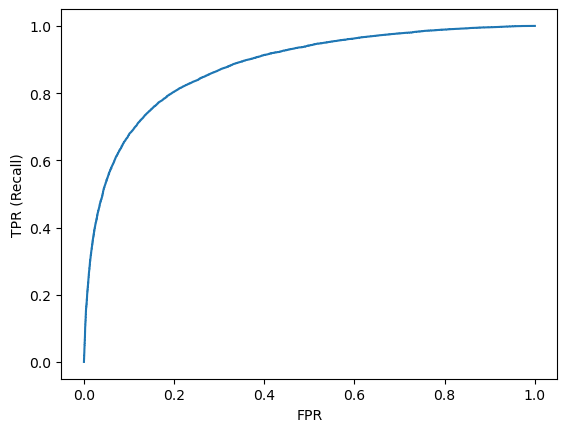

AUC: 0.8800


In [11]:
utilities.display_roc_curve(y_true=y_val[:, 0], y_score=y_val_pred[:, 0])

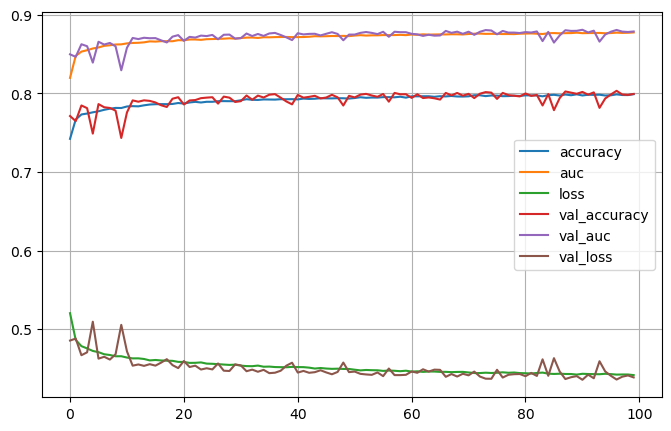

In [12]:
utilities.plot_hist_trainning(history)

In [13]:
utilities.save_model(jet_tag_model, history, "QuarkGluon_Tagging_ParticleCloud")